<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/018_Cosine_Similarity_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📐 Cosine Similarity: Matematyka Wyszukiwania

Kiedy wpisujesz w Google "Jak naprawić pralkę?", silnik nie szuka słów, które leżą "blisko" na osi liczbowej. On szuka słów, które "zmierzają w tym samym kierunku" tematycznym.

Mamy dwie metody porównywania wektorów:
1.  **Odległość Euklidesowa (Linijka):** Mierzy dystans między punktami A i B.
2.  **Podobieństwo Kosinusowe (Kątomierz):** Mierzy kąt między wektorami.

**Dlaczego Kosinus?**
Wyobraź sobie dwa teksty o **ekonomii**:
*   Tekst A: Krótka notatka (100 słów).
*   Tekst B: Długa książka (100 000 słów).

Dla "Linijki" te teksty są bardzo daleko od siebie (bo jeden wektor jest krótki, a drugi gigantyczny).
Dla "Kątomierza" one wskazują **ten sam kierunek** (temat: ekonomia). Kąt między nimi wynosi zero.

Dlatego w AI (Semantic Search) używamy Kosinusa.

Wektor A (Sport krótki): [[1.  0.2]]
Wektor B (Sport długi):  [[10  2]]
Wektor C (Polityka):     [[0.5 5. ]]


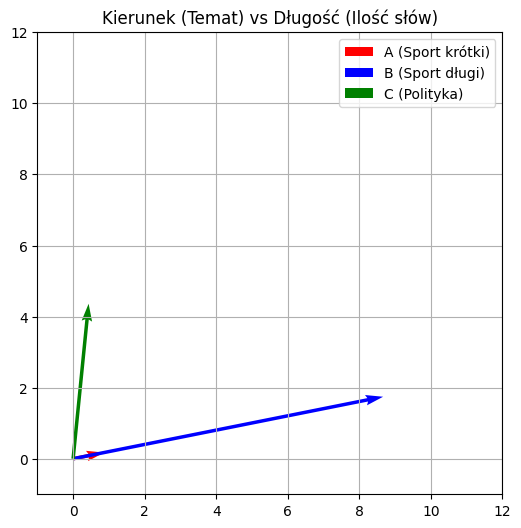

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# 1. DEFINIUJEMY WEKTORY (Tematyka)
# Wyobraźmy sobie oś X = "Sport", oś Y = "Polityka"

# Wektor A: Krótki artykuł o sporcie
vec_a = np.array([[1, 0.2]]) 

# Wektor B: Bardzo długa książka o sporcie (Ten sam temat, ale większe liczby!)
vec_b = np.array([[10, 2]])  

# Wektor C: Artykuł o polityce
vec_c = np.array([[0.5, 5]])

print(f"Wektor A (Sport krótki): {vec_a}")
print(f"Wektor B (Sport długi):  {vec_b}")
print(f"Wektor C (Polityka):     {vec_c}")

# Rysujemy to
plt.figure(figsize=(6, 6))
origin = [0], [0]
plt.quiver(*origin, vec_a[0,0], vec_a[0,1], color='r', scale=15, label='A (Sport krótki)')
plt.quiver(*origin, vec_b[0,0], vec_b[0,1], color='b', scale=15, label='B (Sport długi)')
plt.quiver(*origin, vec_c[0,0], vec_c[0,1], color='g', scale=15, label='C (Polityka)')
plt.xlim(-1, 12)
plt.ylim(-1, 12)
plt.legend()
plt.grid()
plt.title("Kierunek (Temat) vs Długość (Ilość słów)")
plt.show()

## Pojedynek: Euklides vs Kosinus

Teraz policzmy matematycznie, które dokumenty są do siebie podobne.

*   Jeśli użyjemy **Euklidesa** (odległość), komputer powie: *"A jest bliżej C, niż B!"*. (Bzdura, bo A i C to inne tematy).
*   Jeśli użyjemy **Kosinusa** (kąt), komputer powie: *"A i B to prawie to samo"*. (Prawda!).

In [2]:
# 1. Odległość Euklidesowa (Im mniej tym lepiej)
dist_ab = euclidean_distances(vec_a, vec_b)[0][0]
dist_ac = euclidean_distances(vec_a, vec_c)[0][0]

print("--- ODLEGŁOŚĆ EUKLIDESOWA (Linijka) ---")
print(f"Dystans A <-> B (Sport vs Sport):    {dist_ab:.2f}")
print(f"Dystans A <-> C (Sport vs Polityka): {dist_ac:.2f}")
print("WERDYKT: Według Euklidesa tekst o sporcie jest bardziej podobny do polityki (5.02) niż do książki o sporcie (9.18)!")
print("❌ BŁĄD LOGICZNY.\n")

# 2. Podobieństwo Kosinusowe (Im bliżej 1.0 tym lepiej)
# 1.0 = Identyczny kierunek
# 0.0 = Kąt prosty (brak związku)
# -1.0 = Przeciwieństwo

sim_ab = cosine_similarity(vec_a, vec_b)[0][0]
sim_ac = cosine_similarity(vec_a, vec_c)[0][0]

print("--- PODOBIEŃSTWO KOSINUSOWE (Kątomierz) ---")
print(f"Podobieństwo A <-> B (Sport vs Sport):    {sim_ab:.4f}")
print(f"Podobieństwo A <-> C (Sport vs Polityka): {sim_ac:.4f}")
print("WERDYKT: Według Kosinusa teksty o sporcie są identyczne tematycznie (1.0000).")
print("✅ SUKCES.")

--- ODLEGŁOŚĆ EUKLIDESOWA (Linijka) ---
Dystans A <-> B (Sport vs Sport):    9.18
Dystans A <-> C (Sport vs Polityka): 4.83
WERDYKT: Według Euklidesa tekst o sporcie jest bardziej podobny do polityki (5.02) niż do książki o sporcie (9.18)!
❌ BŁĄD LOGICZNY.

--- PODOBIEŃSTWO KOSINUSOWE (Kątomierz) ---
Podobieństwo A <-> B (Sport vs Sport):    1.0000
Podobieństwo A <-> C (Sport vs Polityka): 0.2927
WERDYKT: Według Kosinusa teksty o sporcie są identyczne tematycznie (1.0000).
✅ SUKCES.


## Mini-Wyszukiwarka (RAG Engine)

Zbudujmy prosty silnik wyszukiwania.
Mamy "Bazę Wiedzy" (kilka zdań).
Użytkownik zadaje pytanie.
Znajdziemy zdanie, które ma największe *Cosine Similarity* do pytania.

*Uwaga: Użyjemy prostego `CountVectorizer` do zamiany słów na liczby, w prawdziwym RAG użylibyśmy OpenAI Embeddings, ale matematyka jest ta sama.*

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# BAZA WIEDZY
baza_zdan = [
    "Python to wspaniały język programowania",   # ID 0
    "Jutro pójdę do sklepu kupić mleko",         # ID 1
    "Sztuczna inteligencja zmienia świat",       # ID 2
    "Lubię programować w Pythonie wieczorami"    # ID 3
]

# PYTANIE UŻYTKOWNIKA
pytanie = ["Chcę nauczyć się kodować w Pythonie"]

# 1. Zamiana wszystkiego na liczby (Wektoryzacja)
vectorizer = CountVectorizer()
# Uczymy się słów z bazy ORAZ pytania
wszystkie_teksty = baza_zdan + pytanie
matrix = vectorizer.fit_transform(wszystkie_teksty)

# Rozdzielamy wektory bazy i pytania
vectors_baza = matrix[:-1] # Wszystko oprócz ostatniego
vector_pytanie = matrix[-1] # Ostatni element (nasze pytanie)

# 2. Obliczamy podobieństwo pytania do KAŻDEGO zdania w bazie
scores = cosine_similarity(vector_pytanie, vectors_baza)

# 3. Wyniki
print(f"Pytanie: '{pytanie[0]}'\n")
print("--- WYNIKI WYSZUKIWANIA ---")

# Spłaszczamy wyniki do listy 1D
scores_list = scores[0]

# Sortujemy wyniki (trick z argsort)
najlepsze_id = np.argmax(scores_list)

for i, score in enumerate(scores_list):
    print(f"Zdanie {i}: '{baza_zdan[i]}'")
    print(f" -> Podobieństwo: {score:.4f}")
    
print("-" * 30)
print(f"🏆 ZWYCIĘZCA: '{baza_zdan[najlepsze_id]}'")

Pytanie: 'Chcę nauczyć się kodować w Pythonie'

--- WYNIKI WYSZUKIWANIA ---
Zdanie 0: 'Python to wspaniały język programowania'
 -> Podobieństwo: 0.0000
Zdanie 1: 'Jutro pójdę do sklepu kupić mleko'
 -> Podobieństwo: 0.0000
Zdanie 2: 'Sztuczna inteligencja zmienia świat'
 -> Podobieństwo: 0.0000
Zdanie 3: 'Lubię programować w Pythonie wieczorami'
 -> Podobieństwo: 0.2236
------------------------------
🏆 ZWYCIĘZCA: 'Lubię programować w Pythonie wieczorami'


## 🧠 Podsumowanie: Sekret RAG

Właśnie zbudowałeś serce systemu **RAG (Retrieval Augmented Generation)**.

Kiedy rozmawiasz z botem o swojej firmie:
1.  Bot nie czyta wszystkich Twoich dokumentów naraz (nie zmieściłyby się w pamięci).
2.  Bot zamienia Twoje pytanie na wektor.
3.  Używa **Cosine Similarity**, żeby znaleźć w bazie wektorowej (np. Pinecone) 3 fragmenty tekstu najbardziej pasujące tematycznie (najmniejszy kąt).
4.  Wkleja te 3 fragmenty do GPT-4 i mówi: *"Na podstawie tych fragmentów odpowiedz na pytanie"*.

**Tu jest haczyk.**
Jeśli Twoje wektory są słabe (np. używasz prostego liczenia słów jak my tutaj, zamiast OpenAI Embeddings), to Cosine Similarity też zadziała słabo (np. nie zrozumie synonimów "auto" i "samochód").
Ale sama matematyka porównywania pozostaje ta sama: **Szukamy Kąta, nie Odległości.**